# Effectuez une prédiction de revenus
## Importation des modules et des données nécessaires 
### Préparation des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import plotly.graph_objects as go
import quantecon as qe


# pandas settings for see more row/column
pd.set_option('display.max_row', 110)
pd.set_option('display.max_column', 110)



# data_noclean = pd.read_csv("../dataset/data-projet7.csv") #lire fichier csv


data_income = (pd.read_csv("../P07_Coriton_Jules/dataset/data-projet7.csv", usecols=['country', 'quantile', 'income', "gdpppp"], decimal=',')).rename(columns ={"country" : "Country Code"}) #lire fichier csv


# méthode pour récupérer les valeur les plus réçentes
def func(x):
    if x.last_valid_index() is None:
        return None
    else:
        return x[x.last_valid_index()]

# Indice de Gini PPP, 167 Pays avec valeurs, 162 avec valeurs c'est 20 dernière années (97% des informations)

data_gini = pd.read_csv("../P07_Coriton_Jules/dataset/API_SI.POV.GINI_DS2_en_csv_v2_3011444.csv", header=2) #lire fichier csv
data_gini["Gini_last"] = data_gini.iloc[:,4:65].apply(func, axis=1).round(2)
data_gini["median_gini"] = data_gini.iloc[:,4:65].median(axis=1)
data_gini = (data_gini[["Country Name", "Country Code", "Gini_last","median_gini"]])




# data population with years 2008/2013/2018
data_pop = pd.read_csv("../P07_Coriton_Jules/dataset/data_population.csv", header=2)#lire fichier csv

data_pop_2008 = data_pop[[ "Country Name", "Country Code", "2008"]].rename(columns={"2008" : "Population"}) # 6161622160.0 / 6.700000000 # = 91% de la population total
data_pop_2013 = data_pop[[ "Country Name", "Country Code", "2013"]].rename(columns={"2013" : "Population"}) # 6506860001.0 / 7 Milliards = 92%
data_pop_2018 = data_pop[[ "Country Name", "Country Code", "2018"]].rename(columns={"2018" : "Population"}) # 6861631858 / 7,534 Milliard = 91%




# data_inegalité = pd.read_excel("../P07_Coriton_Jules/dataset/WIID3.4_19JAN2017New.xlsx")#lire fichier csv


# data_inegalité.head(50)

elasticite = pd.read_csv("../P07_Coriton_Jules/dataset/IGE_income_coef_elasticite.csv", delimiter=",", header=0, usecols=['wbcode', 'region', 'IGEincome'])#lire fichier csv




les 3 caractéristiques de la régression linéaire multiple
le revenu des parents, données provenant de la World Income Distribution : pour les quantiles de revenus (exprimés en centile et en PPP) donnée de 2008
le revenu moyen du pays dans lequel habite lA CIBLE (l'enfant des parents clients) données provenant de la World Income Distribution, donnée de 2008
l'indice de Gini calculé sur les revenus des habitants du pays en question.données provenant de la Banque mondiale : indice de Gini (2008) + population totale (2008 - 2013 - 2018)


112 Pays présent avec 100% des données, la plupart des données absentes proviennent des pays qui ont été en instabilité politique(afghanistan, Liby...), ou des petites principauté (Andore, Hong-Kong...) ou des ïles (Cuba, ïles Caiman ...). L'ensemble des données rassemble plus de 90% de la population total pour chaque années étudiées.

utiliser parité du pouvoir d'achat de la colonne income.
Quoi : revenus avec une unité commune, moyenne géométrique des taux de change des biens de consommation.
Pourquoi : rend la comparaison des pays pour les revenus possible.


Échantillonner une population en utilisant des quantiles est selon moi une bonne méthode car elle permet de créer des classes de revenu facilement et ainsi permettre de comparé deux classes de revenu similaire dans différents pays.

In [2]:
# data_income.isnull().sum().sum() 200 valeur nan
data_income.isnull().any()
# .rename(columns={"A": "a", "B": "c"})



data = data_gini.merge(data_pop_2008[["Population","Country Code", "Country Name"]] , on=['Country Code', "Country Name"] , how='outer')
data = data_income.merge(data, on="Country Code" , how='outer')
data = data.dropna()


# # .replace([0, 1, 2, 3], [4, 3, 2, 1])

# data#.isnull().sum()# 11499 raw
# # data.head(60)
# # data[data.isna().any(axis=1)]



# data_gini = pd.read_csv("../P07_Coriton_Jules/dataset/API_SI.POV.GINI_DS2_en_csv_v2_3011444.csv", header=2) #lire fichier csv

# data_gini.iloc[:,4:65].last_valid_index()






data_gini.sort_values("Gini_last", ascending = True).iloc[160:,:]
# data_gini.head(50)


# data[data["quantile"] == 1].sort_values("Population", ascending = False)

# 6861631858.0 / 7534000000
data#.sort_values(by='Gini_last', ascending=False)


,Country Code,quantile,income,gdpppp,Country Name,Gini_last,median_gini,Population
0,ALB,1.0,728.89795,7297.00000,Albania,33.2,31.70,2947314.0
1,ALB,2.0,916.66235,7297.00000,Albania,33.2,31.70,2947314.0
2,ALB,3.0,1010.91600,7297.00000,Albania,33.2,31.70,2947314.0
3,ALB,4.0,1086.90780,7297.00000,Albania,33.2,31.70,2947314.0
4,ALB,5.0,1132.69970,7297.00000,Albania,33.2,31.70,2947314.0
...,...,...,...,...,...,...,...,...
11594,COD,96.0,810.62330,303.19305,"Congo, Dem. Rep.",42.1,42.15,60411195.0
11595,COD,97.0,911.78340,303.19305,"Congo, Dem. Rep.",42.1,42.15,60411195.0
11596,COD,98.0,1057.80740,303.19305,"Congo, Dem. Rep.",42.1,42.15,60411195.0
11597,COD,99.0,1286.60290,303.19305,"Congo, Dem. Rep.",42.1,42.15,60411195.0


data

In [3]:
# regard rapide sur les données , top 5 et cas de la France
gini = data[data["quantile"] == 50].sort_values(by='Gini_last', ascending=False)
gini = gini.reset_index()
print(gini.head(5))
print(gini.tail(5))
print(gini[gini['Country Name']=='France'])
gini['Gini_last'].describe()

   index Country Code  quantile      income  gdpppp              Country Name  \
0  11448          ZAF      50.0  2030.94200  9602.0              South Africa   
1   1449          CAF      50.0   441.09370   685.0  Central African Republic   
2   9848          SWZ      50.0   347.41815  4748.0                  Eswatini   
3   7348          MOZ      50.0   467.70710   773.0                Mozambique   
4   1249          BRA      50.0  2768.40110  9559.0                    Brazil   

   Gini_last  median_gini   Population  
0       63.0        63.00   49779472.0  
1       56.2        58.75    4273368.0  
2       54.6        53.85    1049948.0  
3       54.0        50.30   22276596.0  
4       53.4        57.60  192030362.0  
     index Country Code  quantile      income   gdpppp     Country Name  \
107   6648          MDA      50.0   1805.2925   2768.0          Moldova   
108   1049          BLR      50.0   3493.3580  11651.0          Belarus   
109   2349          CZE      50.0   7298.8

count    112.000000
mean      36.854464
std        7.489511
min       24.600000
25%       31.825000
50%       35.550000
75%       41.525000
max       63.000000
Name: Gini_last, dtype: float64

In [4]:
# créer une echelle logarithmique 
data['income_log'] = np.log(data['income'])

# mise sous forme de tableau pour créer des cluster
income_country_quantile = pd.pivot_table(data[['income_log', 'Country Name', 'quantile']], index='Country Name', columns='quantile', values='income_log',fill_value=0)

from scipy.cluster.hierarchy import linkage
linkage_matrix = linkage(income_country_quantile, method='median', metric='euclidean', optimal_ordering=True)

from scipy.cluster.hierarchy import fcluster
groups = fcluster(linkage_matrix, criterion='maxclust', t=5, depth=3)

income_country_quantile['group'] = groups.reshape(-1,1)

for group_number in income_country_quantile['group'].unique():
    index = income_country_quantile[income_country_quantile['group']==group_number].index
    display((data[(data['Country Name'].isin(index))]).sort_values("Gini_last"))
    display((data[(data['Country Name'].isin(index))]).sort_values("Gini_last").mean())
    
income_country_quantile

,Country Code,quantile,income,gdpppp,Country Name,Gini_last,median_gini,Population,income_log
9548,SVK,50.0,5693.6294,20515.0,Slovak Republic,25.0,26.3,5379233.0,8.647103
9572,SVK,74.0,7141.7583,20515.0,Slovak Republic,25.0,26.3,5379233.0,8.873714
9571,SVK,73.0,7075.1045,20515.0,Slovak Republic,25.0,26.3,5379233.0,8.864337
9570,SVK,72.0,6986.9160,20515.0,Slovak Republic,25.0,26.3,5379233.0,8.851795
9569,SVK,71.0,6906.9230,20515.0,Slovak Republic,25.0,26.3,5379233.0,8.840280
...,...,...,...,...,...,...,...,...,...
11426,ZAF,28.0,988.3187,9602.0,South Africa,63.0,63.0,49779472.0,6.896005
11425,ZAF,27.0,956.1989,9602.0,South Africa,63.0,63.0,49779472.0,6.862966
11424,ZAF,26.0,920.8510,9602.0,South Africa,63.0,63.0,49779472.0,6.825298
11434,ZAF,36.0,1310.9304,9602.0,South Africa,63.0,63.0,49779472.0,7.178492


quantile       5.050000e+01
income         4.583287e+03
gdpppp         1.005979e+04
Gini_last      4.012895e+01
median_gini    4.274605e+01
Population     6.440253e+07
income_log     8.017663e+00
dtype: float64

,Country Code,quantile,income,gdpppp,Country Name,Gini_last,median_gini,Population,income_log
6625,MDA,27.0,1308.4453,2768.0,Moldova,25.7,34.55,2867964.0,7.176595
6626,MDA,28.0,1324.6482,2768.0,Moldova,25.7,34.55,2867964.0,7.188902
6627,MDA,29.0,1344.7144,2768.0,Moldova,25.7,34.55,2867964.0,7.203937
6628,MDA,30.0,1367.4395,2768.0,Moldova,25.7,34.55,2867964.0,7.220695
6629,MDA,31.0,1388.2848,2768.0,Moldova,25.7,34.55,2867964.0,7.235824
...,...,...,...,...,...,...,...,...,...
3926,GTM,27.0,662.2568,4367.0,Guatemala,48.3,54.60,13739299.0,6.495653
3925,GTM,26.0,641.7991,4367.0,Guatemala,48.3,54.60,13739299.0,6.464275
3924,GTM,25.0,624.2247,4367.0,Guatemala,48.3,54.60,13739299.0,6.436510
3922,GTM,23.0,590.0174,4367.0,Guatemala,48.3,54.60,13739299.0,6.380152


quantile       5.050000e+01
income         1.637147e+03
gdpppp         1.626600e+05
Gini_last      3.489259e+01
median_gini    3.555000e+01
Population     8.383618e+07
income_log     7.126246e+00
dtype: float64

,Country Code,quantile,income,gdpppp,Country Name,Gini_last,median_gini,Population,income_log
9652,SVN,54.0,11534.228,27197.0,Slovenia,24.6,24.8,2021316.0,9.353074
9626,SVN,28.0,8853.661,27197.0,Slovenia,24.6,24.8,2021316.0,9.088586
9627,SVN,29.0,8953.777,27197.0,Slovenia,24.6,24.8,2021316.0,9.099831
9628,SVN,30.0,9059.874,27197.0,Slovenia,24.6,24.8,2021316.0,9.111610
9629,SVN,31.0,9159.760,27197.0,Slovenia,24.6,24.8,2021316.0,9.122575
...,...,...,...,...,...,...,...,...,...
10927,USA,29.0,12000.025,43261.0,United States,41.4,40.5,304093966.0,9.392664
10926,USA,28.0,11691.000,43261.0,United States,41.4,40.5,304093966.0,9.366575
10925,USA,27.0,11372.998,43261.0,United States,41.4,40.5,304093966.0,9.338997
10935,USA,37.0,14491.445,43261.0,United States,41.4,40.5,304093966.0,9.581314


quantile       5.050000e+01
income         1.649196e+04
gdpppp         3.258281e+04
Gini_last      3.143704e+01
median_gini    3.142963e+01
Population     3.485846e+07
income_log     9.481460e+00
dtype: float64

,Country Code,quantile,income,gdpppp,Country Name,Gini_last,median_gini,Population,income_log
10199,TLS,1.0,204.18102,1113.1322,Timor-Leste,28.7,28.70,1055428.0,5.319007
10271,TLS,73.0,794.28516,1113.1322,Timor-Leste,28.7,28.70,1055428.0,6.677443
10270,TLS,72.0,782.09600,1113.1322,Timor-Leste,28.7,28.70,1055428.0,6.661977
10269,TLS,71.0,770.37180,1113.1322,Timor-Leste,28.7,28.70,1055428.0,6.646873
10268,TLS,70.0,756.72217,1113.1322,Timor-Leste,28.7,28.70,1055428.0,6.628996
...,...,...,...,...,...,...,...,...,...
1471,CAF,72.0,735.62730,685.0000,Central African Republic,56.2,58.75,4273368.0,6.600724
1473,CAF,74.0,775.84720,685.0000,Central African Republic,56.2,58.75,4273368.0,6.653956
1474,CAF,75.0,800.18900,685.0000,Central African Republic,56.2,58.75,4273368.0,6.684848
1463,CAF,64.0,596.04900,685.0000,Central African Republic,56.2,58.75,4273368.0,6.390323


quantile       5.050000e+01
income         6.561460e+02
gdpppp         1.387226e+03
Gini_last      4.085263e+01
median_gini    4.227895e+01
Population     2.665118e+07
income_log     6.147615e+00
dtype: float64

,Country Code,quantile,income,gdpppp,Country Name,Gini_last,median_gini,Population,income_log
6200,LTU,1.0,566.3453,17571.0,Lithuania,35.7,35.7,3198231.0,6.339204
6271,LTU,73.0,7735.5150,17571.0,Lithuania,35.7,35.7,3198231.0,8.953577
6270,LTU,72.0,7578.0720,17571.0,Lithuania,35.7,35.7,3198231.0,8.933014
6269,LTU,71.0,7461.7430,17571.0,Lithuania,35.7,35.7,3198231.0,8.917544
6268,LTU,70.0,7377.1690,17571.0,Lithuania,35.7,35.7,3198231.0,8.906145
6267,LTU,69.0,7233.9300,17571.0,Lithuania,35.7,35.7,3198231.0,8.886538
6266,LTU,68.0,7121.1353,17571.0,Lithuania,35.7,35.7,3198231.0,8.870822
6265,LTU,67.0,7021.7725,17571.0,Lithuania,35.7,35.7,3198231.0,8.856771
6264,LTU,66.0,6909.9780,17571.0,Lithuania,35.7,35.7,3198231.0,8.840722
6263,LTU,65.0,6807.5670,17571.0,Lithuania,35.7,35.7,3198231.0,8.825790


quantile       5.059596e+01
income         6.641248e+03
gdpppp         1.757100e+04
Gini_last      3.570000e+01
median_gini    3.570000e+01
Population     3.198231e+06
income_log     8.602139e+00
dtype: float64

quantile,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0,group
Country Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Albania,6.591534,6.820739,6.918612,6.991092,7.032359,7.065734,7.091020,7.123590,7.159052,7.189359,7.208831,7.229798,7.256144,7.291027,7.315641,7.336722,7.360036,7.380790,7.400412,7.420527,7.444093,7.465307,7.476092,7.489883,7.507610,7.520058,7.530079,7.539407,7.551581,7.564785,7.575814,7.584542,7.597785,7.613921,7.629470,7.642984,7.656927,7.669389,7.682609,7.694217,7.703638,7.722483,7.736904,7.748626,7.759476,7.769677,7.780860,7.789120,7.804124,7.821578,7.830368,7.842248,7.857560,7.872644,7.883502,7.897234,7.911160,7.923101,7.933547,7.944668,7.956380,7.969737,7.985454,8.000232,8.008961,8.026520,8.040294,8.053960,8.065148,8.080414,8.095835,8.114171,8.128820,8.143118,8.157961,8.177477,8.193227,8.208283,8.228782,8.248041,8.267336,8.293775,8.315930,8.340047,8.365687,8.393422,8.406924,8.431024,8.448981,8.470895,8.510307,8.545758,8.584626,8.633988,8.676061,8.737308,8.827955,8.958783,9.143319,9.784384,2
Argentina,5.537686,6.153799,6.435275,6.599836,6.724215,6.822642,6.920139,7.008850,7.077504,7.146535,7.198957,7.230473,7.293031,7.345895,7.392662,7.431106,7.469009,7.508662,7.548701,7.588051,7.616959,7.646855,7.682522,7.709207,7.737549,7.767734,7.795465,7.822989,7.850310,7.877668,7.898103,7.917919,7.944591,7.971474,7.995551,8.018050,8.038368,8.066181,8.096504,8.108135,8.133157,8.148524,8.182094,8.203437,8.227473,8.251907,8.278323,8.289896,8.314103,8.326678,8.351402,8.371461,8.391747,8.413884,8.434561,8.452687,8.473680,8.497085,8.513846,8.536854,8.557499,8.578008,8.604928,8.624621,8.648820,8.674028,8.696661,8.722177,8.745493,8.771558,8.794877,8.809364,8.828571,8.853031,8.882136,8.911486,8.939302,8.970697,8.997723,9.020832,9.050477,9.079228,9.107645,9.136329,9.176386,9.211226,9.241193,9.281214,9.317750,9.359194,9.401842,9.458867,9.506798,9.567763,9.642516,9.718294,9.810644,9.929560,10.104179,10.684399,2
Armenia,5.904320,6.282878,6.416153,6.489721,6.537919,6.581900,6.625173,6.665574,6.695907,6.722137,6.748125,6.767275,6.786031,6.803950,6.820910,6.835613,6.850283,6.867266,6.881022,6.893594,6.909011,6.923088,6.939716,6.952446,6.963925,6.974650,6.985708,6.996577,7.010532,7.021641,7.032737,7.044827,7.058466,7.071774,7.084977,7.096829,7.109496,7.121975,7.134003,7.145923,7.156051,7.167365,7.181246,7.191261,7.202540,7.215111,7.228235,7.240293,7.252124,7.264139,7.276888,7.287958,7.298748,7.307935,7.318742,7.329233,7.342351,7.353228,7.364724,7.375915,7.387297,7.395895,7.406478,7.417419,7.430347,7.443719,7.456368,7.467413,7.483103,7.497598,7.509898,7.524145,7.538812,7.553236,7.566432,7.581103,7.598272,7.615462,7.633179,7.648919,7.665259,7.682037,7.703056,7.722609,7.741536,7.763896,7.784977,7.805289,7.829165,7.851674,7.883665,7.915168,7.949088,7.983631,8.027103,8.080099,8.150948,8.231802,8.371078,8.789684,3
Austria,7.992294,8.495656,8.605140,8.686697,8.760967,8.821624,8.861696,8.897844,8.933408,8.956659,8.981735,9.008992,9.037775,9.062281,9.084162,9.103909,9.124611,9.145911,9.160702,9.179376,9.196548,9.215827,9.235983,9.258784,9.264268,9.277793,9.292516,9.303381,9.314090,9.325895,9.335779,9.348401,9.364055,9.383512,9.396683,9.410159,9.424948,9.438555,9.455312,9.467799,9.477768,9.491734,9.503663,9.517495,9.530806,9.541549,9.552558,9.565972,9.578218,9.586714,9.598519,9.607459,9.619015,9.631135,9.645666,9.658249,9.667302,9.677296,9.690465,9.703357,9.716073,9.729032,9.742539,9.753881,9.762118,9.769947,9.780197,9.794451,9.809190,9.824834,9.83868

,Country Code,quantile,income,gdpppp,Country Name,Gini_last,median_gini,Population,income_log
3300,FRA,1.0,2958.3040,30357.0,France,32.4,32.4,64374979.0,7.992371
3301,FRA,2.0,4412.6753,30357.0,France,32.4,32.4,64374979.0,8.392236
3302,FRA,3.0,4939.6350,30357.0,France,32.4,32.4,64374979.0,8.505047
3303,FRA,4.0,5422.9165,30357.0,France,32.4,32.4,64374979.0,8.598389
3304,FRA,5.0,5906.5376,30357.0,France,32.4,32.4,64374979.0,8.683815
...,...,...,...,...,...,...,...,...,...
11494,ZAF,96.0,24553.5680,9602.0,South Africa,63.0,63.0,49779472.0,10.108612
11495,ZAF,97.0,28858.0310,9602.0,South Africa,63.0,63.0,49779472.0,10.270144
11496,ZAF,98.0,35750.2900,9602.0,South Africa,63.0,63.0,49779472.0,10.484314
11497,ZAF,99.0,46297.3160,9602.0,South Africa,63.0,63.0,49779472.0,10.742839


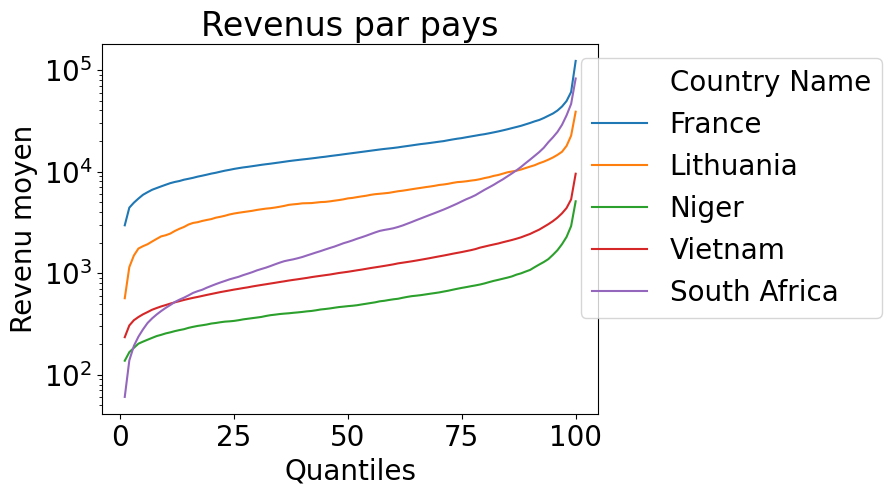

In [5]:
five_countries = ['ZAF', 'VNM', 'FRA', 'NER', 'LTU']  #lituanie, Niger, France, country_filter, Afrique du sud

five_countries = data[data['Country Code'].isin(five_countries)]

plt.style.use('default')
plt.rcParams.update({'font.size': 20})

# incomes_filter = incomes_filter.iloc[:, 1:]

# graph settings
sns.lineplot(x=five_countries['quantile'], y=five_countries['income'], hue=five_countries['Country Name'])
plt.yscale("log") #met en échelle log
plt.xlabel("Quantiles")
plt.ylabel("Revenu moyen")
plt.title("Revenus par pays")
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.5, 0.5, 0.5))
plt.savefig('Graph\P7_02_revenus_moyens_par quantile_5pays.png', bbox_inches='tight');

five_countries

courbe de Lorenz

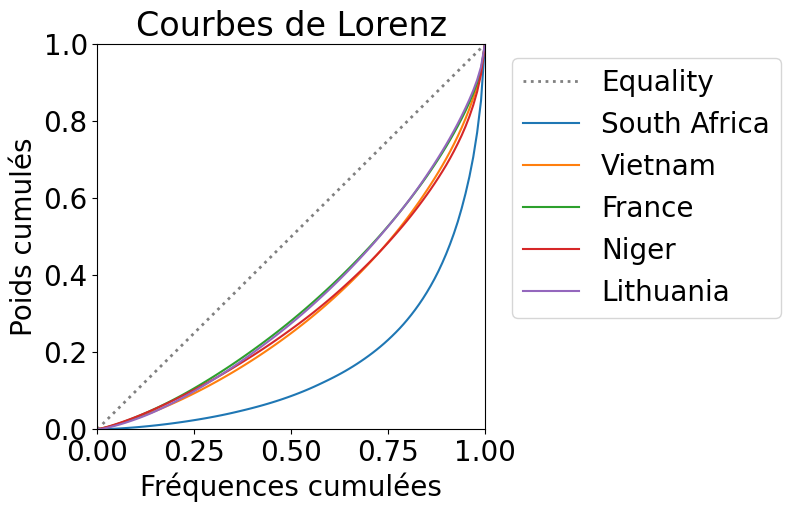

In [6]:
# set graph
plt.figure(figsize=(5,5),dpi=100)
plt.axis(xmin=0, xmax=1 ,ymin=0, ymax=1)
plt.ylabel('Poids cumulés')
plt.xlabel('Fréquences cumulées')
plt.title('Courbes de Lorenz')

# plot equality line
plt.plot([0, 1], lw=2, c='gray', ls='dotted', label='Equality') #courbe de base


five_countries = ['ZAF', 'VNM', 'FRA', 'NER', 'LTU']  #lituanie, Niger, France, vietnam, Afrique du sud
for country_code in five_countries:
    country_filter = data[data['Country Code']==country_code]

    # compute lorenz curve
    cum_frequences, cum_weights = qe.lorenz_curve(np.array(country_filter['income']))
    
    # plot the Lorenz curve
    sns.lineplot(cum_frequences, cum_weights, label=country_filter['Country Name'].unique()[0])

plt.legend(loc='upper right', bbox_to_anchor=((1.3, 0.5, 0.5, 0.5)))
plt.savefig('Graph\P7_03_Lorenz_5pays.png', bbox_inches='tight');






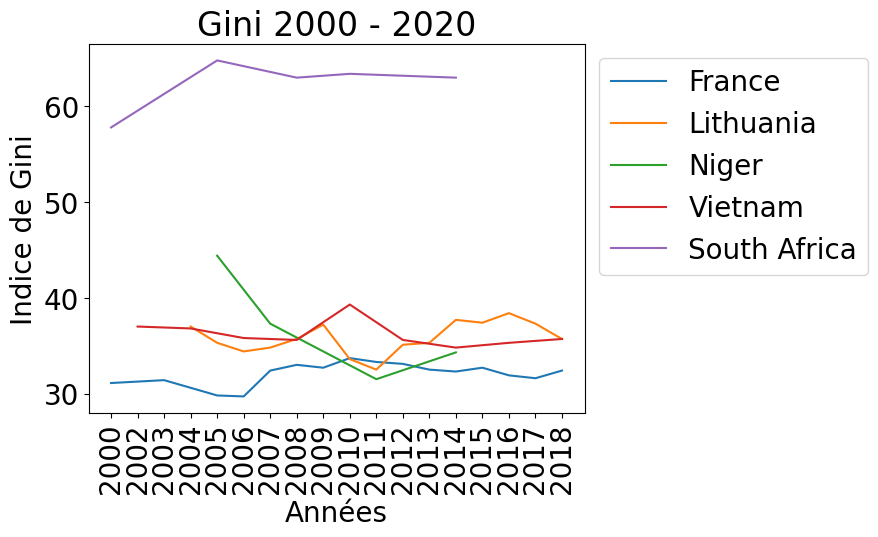

In [7]:
# filter with selected countries
gini = pd.read_csv("../P07_Coriton_Jules/dataset/API_SI.POV.GINI_DS2_en_csv_v2_3011444.csv", header=2) #lire fichier csv

gini_by_years = gini[gini['Country Code'].isin(five_countries)].drop(columns=['Country Code', 'Indicator Code', 'Indicator Name'])
gini_by_years = gini_by_years.set_index('Country Name').iloc[:,40:59]
gini_by_years.iloc[0, 2] = (gini_by_years.iloc[0, 0] + gini_by_years.iloc[0, 3])/2




for pays in range(5) : # len(gini_by_years.index):
    sns.lineplot(x=gini_by_years.columns, y=gini_by_years.iloc[pays,:], label=gini_by_years.index[pays])
    plt.xticks(rotation=90)
    plt.title('Gini 2000 - 2020')
    plt.xlabel('Années')
    plt.ylabel('Indice de Gini')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.5, 0.5, 0.5))


    

In [8]:
data_gini = pd.read_csv("../P07_Coriton_Jules/dataset/API_SI.POV.GINI_DS2_en_csv_v2_3011444.csv", header=2) #lire fichier csv
data_gini["Gini_last"] = data_gini.iloc[:,4:65].apply(func, axis=1).round(2)
data_gini["median_gini"] = data_gini.iloc[:,4:65].median(axis=1)
data_gini = (data_gini[["Country Name", "Country Code", "Gini_last","median_gini"]])

display(data_gini["Gini_last"].mean())
display(data_gini.sort_values("Gini_last", ascending = True).head(5))
display(data_gini.sort_values("Gini_last", ascending = False).head(5))


X = ((data_gini.sort_values("Gini_last", ascending = True).reset_index()))
display(X[X["Country Name"] == "France"])
# la france est 38èmes

38.16526946107786

,Country Name,Country Code,Gini_last,median_gini
222,Slovenia,SVN,24.6,24.80
221,Slovak Republic,SVK,25.0,26.30
54,Czech Republic,CZE,25.0,26.20
25,Belarus,BLR,25.3,27.65
150,Moldova,MDA,25.7,34.55


,Country Name,Country Code,Gini_last,median_gini
263,South Africa,ZAF,63.0,63.0
171,Namibia,NAM,59.1,61.0
220,Suriname,SUR,57.9,57.9
264,Zambia,ZMB,57.1,54.3
219,Sao Tome and Principe,STP,56.3,32.1


,index,Country Name,Country Code,Gini_last,median_gini
37,77,France,FRA,32.4,32.4


In [9]:
elasticite.isnull().sum()# 11499 raw


wbcode          0
region          0
IGEincome    5651
dtype: int64

In [10]:
# elasticity coefficient from GDIM
elasticite = pd.read_csv("../P07_Coriton_Jules/dataset/IGE_income_coef_elasticite.csv", delimiter=",", header=0, usecols=['wbcode', 'region', 'IGEincome'])#lire fichier csv

# drop duplicate lines
elasticite = elasticite.drop_duplicates()
elasticite = elasticite.groupby(['wbcode', 'region']).mean().reset_index()
elasticite
# # missing values ratio
print('missing values ', elasticite['IGEincome'].isna().sum()/elasticite.shape[0]*100, '%')

# median imputation for missing values
region = elasticite.groupby('region').median()

for region_name in region.index :
    elasticite.loc[(elasticite['region'] == region_name) 
                       & (elasticite['IGEincome'].isna()), ['IGEincome']]=region.loc[region_name][0]
    
# delete region column, set wbcode index
elasticite = elasticite.iloc[:, [0, 2]].set_index('wbcode').round(2).dropna()



elasticite

missing values  50.0 %


,IGEincome
wbcode,
AFG,0.49
AGO,0.68
ALB,0.82
ARG,0.97
ARM,0.37
...,...
WBG,0.90
YEM,0.90
ZAF,0.68


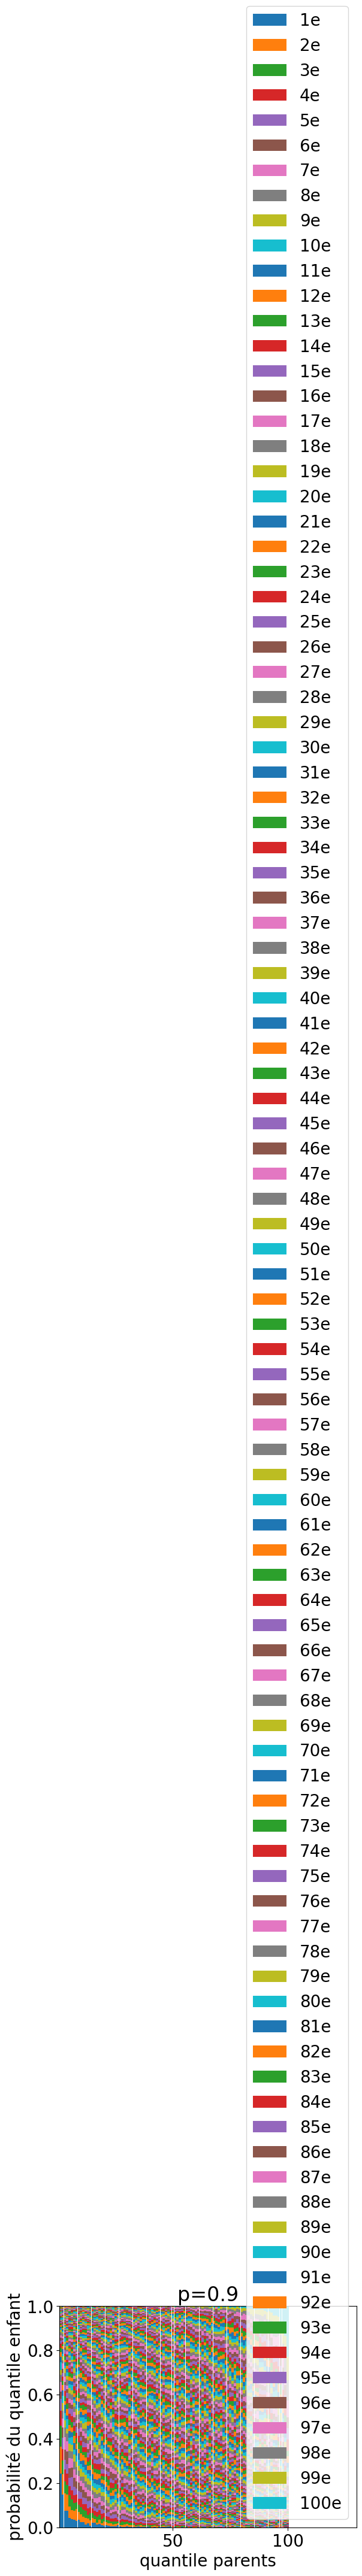

array([[0.244, 0.147, 0.074, ..., 0.   , 0.   , 0.   ],
       [0.121, 0.094, 0.079, ..., 0.   , 0.   , 0.   ],
       [0.095, 0.062, 0.055, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.063, 0.067, 0.093],
       [0.   , 0.   , 0.   , ..., 0.082, 0.092, 0.104],
       [0.   , 0.   , 0.   , ..., 0.088, 0.135, 0.231]])

'\nP(c_i_parent = 80 | c_i_child = 90, pj = 0.9) = 0.022'

In [11]:
import scipy.stats as st
import pandas as pd
import numpy as np
from collections import Counter

def generate_incomes(n, pj): #n = nombre de parent, pj = coefficient d'élasticité des revenus du pays j
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent) # return y_child, y_parents (y = income)
    
def quantiles(l, nb_quantiles):# l= nb d'échantillon (parent=enfant) 
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)} # zip permet d'associer les 2 séries ensemble
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

def plot_conditional_distributions(p, cd, nb_quantiles):
    import matplotlib.pyplot as plt

    plt.figure()
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.savefig('variation_quantile_enfant.png', dpi=300)
    plt.show()
   
    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10
display(cd)

c_i_child = 90 
c_i_parent = 80
p = proba_cond(c_i_parent, c_i_child, cd)
display("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

In [12]:
data_income = (pd.read_csv("../P07_Coriton_Jules/dataset/data-projet7.csv", usecols=['country', 'quantile', 'income', "gdpppp"], decimal=',')).rename(columns ={"country" : "Country Code"}) #lire fichier csv
data_income

,Country Code,quantile,income,gdpppp
0,ALB,1,728.89795,7297.00000
1,ALB,2,916.66235,7297.00000
2,ALB,3,1010.91600,7297.00000
3,ALB,4,1086.90780,7297.00000
4,ALB,5,1132.69970,7297.00000
...,...,...,...,...
11594,COD,96,810.62330,303.19305
11595,COD,97,911.78340,303.19305
11596,COD,98,1057.80740,303.19305
11597,COD,99,1286.60290,303.19305


Éventuellement et pour éviter toute confusion, effacez les individus que vous venez de générer (nous n'en avons plus besoin), et ne gardez que les distributions conditionnelles.

Nous allons maintenant travailler sur un nouvel échantillon. Celui-ci sera créé à partir de la WID. Pour chaque individu de la World Income Distribution, créez-en 499 "clones". La taille de votre nouvel échantillon sera donc 500 fois plus grand que celui de la World Income Distribution.


Pour chaque \(c_{i,child}\) et chaque pays, il y a maintenant 500 individus. Vous attribuerez aux 500 individus leurs classes \( c_{i,parent}\) conformément aux distributions trouvées précédemment. Par exemple, si \(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03\) , alors vous assignerez la classe \(c_{i,parent} = 8\) à 15 des 500 individus du pays \( j\) ayant \(c_{i,child}=5\) , car 500*0.03 = 15.
Éventuellement et pour éviter toute confusion, effacez la variable \(c_{i,child}\)  : nous n'en avons pas besoin pour la mission 4.

Assurez-vous que votre nouvel échantillon contiennent bien les variables initialement présentes dans la World Income Distribution : \(m_j\) et \(G_j\) .

In [13]:
# # c_i_child = 20
# # c_i_parent = 25
# # pj = 0.9                 # coefficient d'élasticité du pays j

# # p = proba_cond(c_i_parent, c_i_child, cd)

# # display("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))



# pj = 0.9                 # coefficient d'élasticité du pays j
# nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
# n  = 500*nb_quantiles   # taille de l'échantillon

# y_child, y_parents = generate_incomes(n, pj)
# sample = compute_quantiles(y_child, y_parents, nb_quantiles)
# sample

In [14]:
# languages = ['Java', 'Python', 'JavaScript']
# versions = [14, 3, 6]

# result = zip(languages, versions)
# print(list(result))




# pj = 0.9                 # coefficient d'élasticité du pays j
# nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
# n  = 500*nb_quantiles   # taille de l'échantillon

# y_child, y_parents = generate_incomes(n, pj)
# # sample = compute_quantiles(y_child, y_parents, nb_quantiles)
# # cd = conditional_distributions(sample, nb_quantiles)
# # display(cd)

# # c_i_child = 90 
# # c_i_parent = 80
# # p = proba_cond(c_i_parent, c_i_child, cd)
# # display("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

# def create(elasticity_coefficient)
#     y_child, y_parents = generate_incomes(500, elasticity_coefficient)





# for coefficient in elasticite['IGEincome'].unique():
#     elasticity_dataframe = pd.concat([elasticity_dataframe,create(coefficient)])
    
    
    
    
    
# def c_i_parent(elasticity_coefficient):
#     # incomes generation
#     y_child, y_parent = generate_incomes(500, elasticity_coefficient)

#     # sample creation
#     sample = compute_quantiles(y_child, y_parent, 100)

#     # conditionnal distribution creation
#     conditionnal_distribution = conditional_distributions(sample, 100)
    
#     return conditionnal_distribution


# def elasticity_parent_class_dataframe(elasticity_coefficient):
    
#     # make sample attribution 1000 individuals per child class
#     sample_attribution = c_i_parent(elasticity_coefficient) * 1000
    
#     # dataframe creation with conditionnal distribution
#     elasticity_dataframe = pd.DataFrame(sample_attribution) 
    
#     # country_code column creation
#     elasticity_dataframe['elasticity_coefficient'] = elasticity_coefficient  
    
#     # create child quantile
#     elasticity_dataframe = elasticity_dataframe.reset_index()
#     elasticity_dataframe = elasticity_dataframe.rename(columns={'index':'quantile'})
#     elasticity_dataframe['quantile'] = elasticity_dataframe['quantile'] + 1
    
#     return elasticity_dataframe


# Mission 3 

faire 500 classes de revenus des parents pour chaque quantile.
en utilisant lecoefficient d'élasticité par pays, héritage des revenu : 0 : forte mobilité, 9 : faible mobilité.
## méthode de création de DF

In [15]:
# free memory space
# del gini, gini_by_years, income_country_quantile, groups, five_countries, country_filter, X

def c_i_parent(elasticity_coefficient):
    # incomes generation
    y_child, y_parent = generate_incomes(5000, elasticity_coefficient) ##### A REMETTRE A 500000 A la FIN !!!!!!!!!

    # sample creation
    sample = compute_quantiles(y_child, y_parent, 100)

    # conditionnal distribution creation
    conditionnal_distribution = conditional_distributions(sample, 100)
    
    return conditionnal_distribution


def elasticity_parent_class_dataframe(elasticity_coefficient):
    
    # make sample attribution 1000 individuals per child class
    sample_attribution = c_i_parent(elasticity_coefficient) * 1000
    
    # dataframe creation with conditionnal distribution
    elasticity_dataframe = pd.DataFrame(sample_attribution) 
    
    # country_code column creation
    elasticity_dataframe['elasticity_coefficient'] = elasticity_coefficient  
    
    # create child quantile
    elasticity_dataframe = elasticity_dataframe.reset_index()
    elasticity_dataframe = elasticity_dataframe.rename(columns={'index':'quantile'})
    elasticity_dataframe['quantile'] = elasticity_dataframe['quantile'] + 1
    
    return elasticity_dataframe



elasticity_dataframe = pd.DataFrame()

# les prochaines lignes sont en commentaire pour gagner du temps lors de chaque relancement du code
# for coefficient in elasticite['IGEincome'].unique():
#     elasticity_dataframe = pd.concat([elasticity_dataframe,elasticity_parent_class_dataframe(coefficient)])
# elasticity_dataframe.to_csv("elasticity_dataframe.csv")   

elasticity_dataframe = pd.read_csv("elasticity_dataframe.csv")

In [16]:
elasticity_dataframe['elasticity_coefficient'].nunique() #55

elasticite.reset_index()['wbcode'].nunique()


150

## Fusion avec le coef pour attribuer les pays

In [17]:
dataset = elasticite.copy()
dataset = dataset.reset_index()

dataset = dataset.merge(elasticity_dataframe,how='left', 
                        left_on='IGEincome', right_on='elasticity_coefficient')

dataset = dataset.drop(columns=['IGEincome', 'elasticity_coefficient'])
dataset = dataset.set_index(['wbcode'])

dataset

,Unnamed: 0,quantile,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
wbcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AFG,0,1,80.0,100.0,20.0,40.0,40.0,20.0,40.0,0.0,40.0,40.0,40.0,0.0,20.0,0.0,0.0,40.0,20.0,40.0,0.0,20.0,20.0,20.0,20.0,0.0,0.0,20.0,0.0,40.0,0.0,0.0,0.0,20.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AFG,1,2,80.0,0.0,40.0,40.0,20.0,20.0,20.0,40.0,20.0,20.0,20.0,0.0,0.0,60.0,40.0,20.0,0.0,0.0,0.0,40.0,40.0,0.0,40.0,40.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,40.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,20.0,0.0,0.0,40.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AFG,2,3,60.0,0.0,20.0,0.0,60.0,60.0,0.0,0.0,20.0,40.0,0.0,0.0,0.0,20.0,0.0,40.0,20.0,20.0,20.0,20.0,40.0,80.0,40.0,20.0,40.0,0.0,0.0,20.0,0.0,20.0,20.0,0.0,20.0,40.0,20.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AFG,3,4,40.0,60.0,80.0,40.0,20.0,0.0,40.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,40.0,0.0,20.0,60.0,0.0,0.0,20.0,60.0,20.0,0.0,20.0,0.0,20.0,0.0,40.0,20.0,20.0,0.0,60.0,0.0,0.0,0.0,0.0,20.0,40.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AFG,4,5,20.0,0.0,80.0,20.0,20.0,20.0,40.0,0.0,20.0,0.0,80.0,20.0,0.0,0.0,20.0,40.0,20.0,20.0,20.0,40.0,0.0,20.0,0.0,20.0,40.0,0.0,40.0,0.0,20.0,60.0,0.0,0.0,20.0,20.0,40.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,40.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZMB,95,96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,40.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,60.0,20.0,20.0,40.0,20.0,20.0,0.0,20.0,20.0,40.0,0.0,40.0,0.0,20.0,100.0,40.0,20.0,0.0,60.0,100.0,0.0,20.0,40.0
ZMB,96,97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,20.0,0.0,60.0,0.0,0.0,20.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,40.0,40.0,20.0,20.0,40.0,40.0,0.0,20.0,20.0,40.0,0.0,20.0,20.0,60.0,20.0,20.0,40.0,40.0,0.0,80.0,20.0,0.0,20.0,40.0,60.0
ZMB,97,98,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## intégrer les revenus moyen

In [18]:
# drop the country with missing quantile
incomes = data_income.set_index(['Country Code'])

# resetting index for dataframe incomes
incomes = incomes.reset_index()
incomes = incomes.set_index(['Country Code', 'quantile'])

# resetting index for dataframe dataset
dataset = dataset.reset_index()
dataset = dataset.rename(columns={'wbcode' : 'Country Code'})
dataset = dataset.set_index(['Country Code', 'quantile'])

# merging with dataset
dataset = dataset.merge(incomes[['income']], left_index=True, right_index=True)

# droping child quantile
dataset = dataset.reset_index()
# dataset = dataset.drop(columns='quantile')

dataset


,Country Code,quantile,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,income
0,CAF,67,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,40.0,20.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,20.0,20.0,0.0,20.0,20.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,20.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,40.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,60.0,60.0,20.0,20.0,20.0,0.0,20.0,0.0,20.0,0.0,0.0,20.0,20.0,20.0,20.0,20.0,0.0,0.0,0.0,20.0,20.0,0.0,639.40936
1,MRT,61,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,20.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,40.0,0.0,0.0,0.0,20.0,0.0,40.0,0.0,20.0,0.0,40.0,0.0,0.0,0.0,0.0,20.0,0.0,40.0,0.0,20.0,40.0,20.0,0.0,60.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,40.0,20.0,0.0,20.0,0.0,20.0,20.0,0.0,20.0,20.0,0.0,20.0,60.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,60.0,0.0,20.0,20.0,20.0,0.0,0.0,0.0,1599.49150
2,KHM,28,27,40.0,20.0,0.0,20.0,0.0,60.0,20.0,40.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,40.0,40.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,20.0,40.0,20.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,20.0,0.0,20.0,0.0,0.0,0.0,20.0,20.0,0.0,20.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,40.0,20.0,0.0,40.0,20.0,0.0,20.0,0.0,20.0,0.0,0.0,20.0,20.0,20.0,0.0,0.0,20.0,40.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,916.50620
3,SDN,67,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,40.0,20.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,20.0,20.0,0.0,20.0,20.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,20.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,40.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,60.0,60.0,20.0,20.0,20.0,0.0,20.0,0.0,20.0,0.0,0.0,20.0,20.0,20.0,20.0,20.0,0.0,0.0,0.0,20.0,20.0,0.0,1160.23670
4,DOM,64,63,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,60.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,20.0,40.0,80.0,20.0,0.0,0.0,20.0,20.0,0.0,0.0,20.0,40.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,20.0,20.0,40.0,0.0,0.0,20.0,0.0,0.0,40.0,20.0,20.0,20.0,0.0,0.0,40.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,20.0,20.0,20.0,0.0,40.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,20.0,0.0,0.0,2979.22970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994,HUN,72,71,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,20.0,20.0,0.0,20.0,20.0,20.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,80.0,0.0,0.0,40.0,40.0,0.0,20.0,0.0,20.0,0.0,0.0,20.0,0.0,40.0,40.0,0.0,0.0,20.0,20.0,0.0,0.0,40.0,20.0,20.0,20.0,20.0,20.0,20.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,60.0,0.0,20.0,0.0,20.0,20.0,0.0,20.0,20.0,0.0,0.0,0.0,20.0,20.0,7084.37940
10995,YEM,91,90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,40.0,0.0,0.0,40.0,0.0,0.0,20.0,20.0,20.0,20.0,20.0,0.0,40.0,0.0,0.0,60.0,20.0,0.0,0.0,0.0,40.0,0.0,20.0,20.0,0.0,80.0,40.0,0.0,40.0,20.0,60.0,20.0,20.0,60.0,20.0,20.0,80.0,40.0,20.0,1810.87760
10996,NLD,37,36,0.0,

## Fusion avec gini pour donner le gini de la répartition générationel des revenus les pays

In [19]:
dataset = dataset.merge(data_gini[['Country Code', 'Gini_last']], on='Country Code')
dataset = dataset.set_index('Country Code')
dataset



,quantile,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,income,Gini_last
Country Code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CAF,67,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,40.0,20.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,20.0,20.0,0.0,20.0,20.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,20.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,40.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,60.0,60.0,20.0,20.0,20.0,0.0,20.0,0.0,20.0,0.0,0.0,20.0,20.0,20.0,20.0,20.0,0.0,0.0,0.0,20.0,20.0,0.0,639.40936,56.2
CAF,1,0,180.0,140.0,100.0,40.0,40.0,20.0,20.0,40.0,20.0,20.0,40.0,20.0,40.0,0.0,20.0,40.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,40.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.92813,56.2
CAF,14,13,0.0,20.0,20.0,0.0,80.0,20.0,80.0,0.0,20.0,20.0,0.0,20.0,20.0,20.0,0.0,40.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,0.0,20.0,20.0,20.0,0.0,0.0,20.0,0.0,0.0,40.0,0.0,0.0,40.0,0.0,80.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,161.76814,56.2
CAF,56,55,0.0,0.0,40.0,20.0,0.0,0.0,20.0,0.0,20.0,0.0,60.0,20.0,40.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,20.0,20.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,20.0,0.0,20.0,20.0,20.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,40.0,0.0,40.0,20.0,20.0,0.0,20.0,20.0,0.0,40.0,20.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,20.0,20.0,40.0,0.0,0.0,0.0,20.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,498.76068,56.2
CAF,69,68,0.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,0.0,20.0,20.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,20.0,0.0,20.0,20.0,0.0,20.0,0.0,20.0,40.0,20.0,40.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,20.0,40.0,0.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,20.0,20.0,20.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,20.0,40.0,0.0,0.0,20.0,40.0,0.0,40.0,20.0,20.0,40.0,0.0,20.0,672.99610,56.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USA,32,31,0.0,0.0,20.0,20.0,0.0,0.0,20.0,0.0,0.0,40.0,20.0,0.0,20.0,0.0,0.0,20.0,20.0,20.0,20.0,40.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,40.0,20.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,20.0,20.0,60.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,20.0,40.0,20.0,20.0,20.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,40.0,0.0,0.0,0.0,20.0,0.0,0.0,20.0,20.0,20.0,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,12927.58500,41.4
USA,45,44,0.0,20.0,20.0,0.0,20.0,20.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,40.0,40.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,20.0,0.0,40.0,0.0,40.0,0.0,40.0,0.0,0.0,0.0,20.0,20.0,20.0,20.0,0.0,0.0,0.0,20.0,20.0,0.0,20.0,20.0,0.0,0.0,20.0,40.0,20.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,20.0,0.0,20.0,0.0,0.0

In [20]:
# dataset['parent_quantile'] = dataset['parent_quantile'].map(lambda x: x.lstrip('Unnamed: '))

# dataset['parent_quantile2'] = 1
# dataset['parent_quantile'] = dataset['parent_quantile'] + 1
# # dataset['parent_quantile'] = dataset['parent_quantile'].astype(int) + dataset['parent_quantile2'].astype(int)
# dataset

## obtenir les données avec le nombre de parent en ligne supplémentaire

In [21]:
# melt class parents
# dataset = dataset.drop(columns=['income', 'Gini_last',"quantile"])

dataset = dataset.reset_index().sort_values(['Country Code'])
dataset = dataset.drop(columns='quantile')


dataset = pd.melt(dataset, id_vars=['Country Code', 'Gini_last', 'income'], 
                  value_name='parent_quantity', var_name='parent_quantile')

# add 1 to quantile number
dataset['parent_quantile'] = dataset['parent_quantile'].map(lambda x: x.lstrip('Unnamed: '))
dataset['parent_quantile'] = dataset['parent_quantile'].astype(int) + 1

# # before repeating rows : deleting parent_quantity = 0
dataset = dataset[dataset['parent_quantity']!=0]

# # create parent quantiles
repeat_list = pd.Series(dataset['parent_quantity'])
dataset = dataset[['Country Code', 'Gini_last', 'income', 'parent_quantile']]


dataset = dataset.apply(np.repeat,repeats=(repeat_list))

dataset


,Country Code,Gini_last,income,parent_quantile
0,ALB,33.2,2318.385,1
0,ALB,33.2,2318.385,1
0,ALB,33.2,2318.385,1
0,ALB,33.2,2318.385,1
0,ALB,33.2,2318.385,1
...,...,...,...,...
1100798,ZAF,63.0,35750.290,100
1100798,ZAF,63.0,35750.290,100
1100798,ZAF,63.0,35750.290,100
1100798,ZAF,63.0,35750.290,100


## améliorer performence en diminuant la taille de la df

In [22]:
dataset['parent_quantile'] = dataset['parent_quantile'].astype(np.uint8)
dataset['income'] = dataset['income'].astype(np.uint32)
dataset['Gini_last'] = dataset['Gini_last'].astype(np.float16)
dataset['Country Code'] = dataset['Country Code'].astype('category')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11438510 entries, 0 to 1100798
Data columns (total 4 columns):
 #   Column           Dtype   
---  ------           -----   
 0   Country Code     category
 1   Gini_last        float16 
 2   income           uint32  
 3   parent_quantile  uint8   
dtypes: category(1), float16(1), uint32(1), uint8(1)
memory usage: 174.5 MB


In [23]:
# free memory space
# del incomes_filter,gini, gini_by_years, income_country_quantile, groups, five_countries, country_filter


dataset
dataset['income'].drop_duplicates()

0        2318
1        1379
2        3671
3        3007
4        1765
         ... 
20455    2284
20595      35
20948      84
21035     121
21716      60
Name: income, Length: 6827, dtype: uint32

# Mission 4
on doit vérifier que les données usivent une loi normal

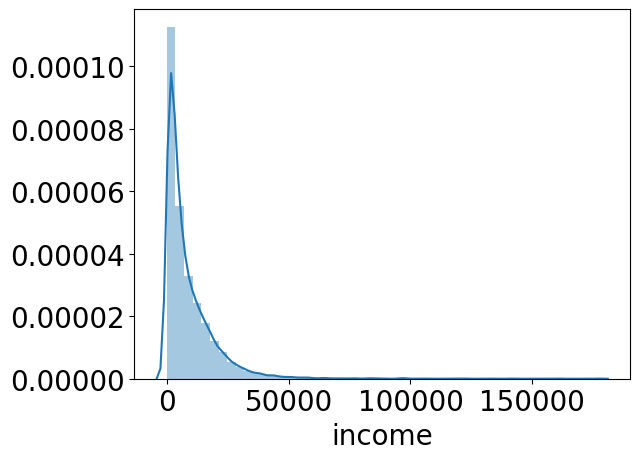

In [24]:
from scipy import stats
from sklearn.preprocessing import RobustScaler

def ks_shapiro_jb(vector):
    
    critical_threshold = 0.001
    shapiro_ok = False
    ks_ok = False
    jb_ok = False
    
    X = vector.values.reshape(-1,1)
    standardized_X = RobustScaler().fit_transform(X)
    
#     shapiro test
    echantillon_standardized_X = np.random.choice(standardized_X.reshape(-1), size=30, replace=False)

    if stats.shapiro(echantillon_standardized_X)[1] >= critical_threshold:
        shapiro_ok = True
        
#     kolmogorov/smirnov test
# The one-sample test performs a test of the distribution F(x) of an observed random variable against 
# a given distribution G(x). Under the null hypothesis, the two distributions are identical, F(x)=G(x). 

    random_normal = np.random.normal(loc=standardized_X.mean(), 
                                     scale=standardized_X.std(), 
                                     size=(standardized_X.shape[0], 1))

    if stats.kstest(standardized_X.reshape(-1), random_normal.reshape(-1), 
                    N=standardized_X.shape[0])[1] >= critical_threshold :
        ks_ok = True

#   test de jarque bera 
# Note that this test only works for a large enough number of data samples (>2000) as the test statistic 
# asymptotically has a Chi-squared distribution with 2 degrees of freedom.

    if stats.jarque_bera(standardized_X.reshape(-1))[1] >= critical_threshold:
        jb_ok = True

    if (shapiro_ok==True) & (ks_ok==True) & (jb_ok==True): 
        return True
    else :
        return False
    
ks_shapiro_jb(dataset['income'].drop_duplicates())
sns.distplot(dataset['income'].drop_duplicates())

False


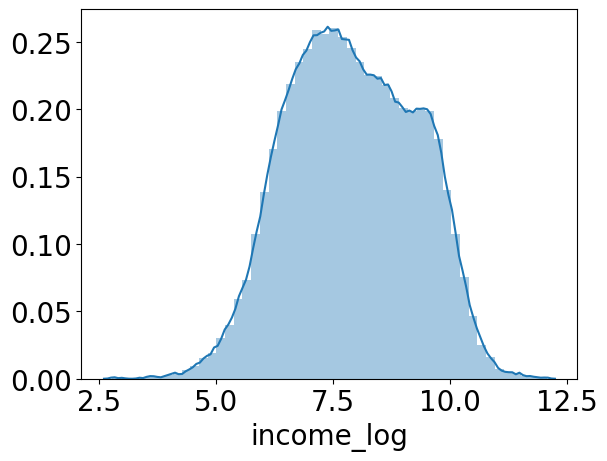

In [25]:
dataset['income_log'] = np.log(np.array(dataset['income']))

print(ks_shapiro_jb(dataset['income'].drop_duplicates()))
sns.distplot(dataset['income_log']);

In [26]:
X = dataset['income_log'].values.reshape(-1,1)
standardized_X = RobustScaler().fit_transform(X)
    
#     shapiro test
echantillon_standardized_X = np.random.choice(standardized_X.reshape(-1), size=30, replace=False)
display(stats.shapiro(echantillon_standardized_X))

#   komorov smirnov test
random_normal = np.random.normal(loc=standardized_X.mean(), 
                                     scale=standardized_X.std(), 
                                     size=(standardized_X.shape[0], 1))

display(stats.kstest(standardized_X.reshape(-1), random_normal.reshape(-1)))


#    Jarque bera test
stats.jarque_bera(standardized_X.reshape(-1))

# test de normalité par pvalue n'a pas donné de bons résultats car la distribution des revenus est bimodale

ShapiroResult(statistic=0.9419832825660706, pvalue=0.10286901891231537)

KstestResult(statistic=0.03569529597823495, pvalue=0.0)

Jarque_beraResult(statistic=165549.6095432486, pvalue=0.0)

Anova

In [27]:
from statsmodels.formula.api import ols

# data preparation (supprime les doublons pour pouvoir faire les calculs)
anova = dataset[['Country Code', 'income']].drop_duplicates()

# renommé la colomns country code par CC pour incorporer dans le model plus facilement (suppression des espaces)
anova.columns=['CC', 'income']

# fitting regression model
model = ols('income ~ CC', data=anova).fit()
pvalues = model.summary2().tables[1][1:]['P>|t|'] #summary permet d'avoir les données du modèle et les valeurs utilisé
# table permet de choisir [0] = les données du modèle ; [1] les valeurs utilisé pour le modèle

# performance analysis
print("Résultat avec les revenus normaux")
print(model.summary().tables[0])



# même opération avec les revenus en log

anova['income'] = np.log(anova['income'])
anova.columns=['CC', 'log_income']

# fitting regression model
model = ols('log_income ~ CC', data=anova).fit()
pvalues = model.summary2().tables[1][1:]['P>|t|']

# performance analysis
print("Résultat avec les revenus en log")
print(model.summary().tables[0])
pvalues

Résultat avec les revenus normaux
                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     96.18
Date:                Tue, 07 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:08:50   Log-Likelihood:            -1.1165e+05
No. Observations:               10899   AIC:                         2.235e+05
Df Residuals:                   10790   BIC:                         2.243e+05
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
Résultat avec les revenus en log
                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:              

CC[T.ARG]     1.217803e-05
CC[T.ARM]     3.145353e-08
CC[T.AUT]     3.388890e-63
CC[T.AZE]     1.604328e-02
CC[T.BEL]     1.372965e-55
CC[T.BFA]     6.359421e-36
CC[T.BGD]     7.262026e-27
CC[T.BGR]     3.896901e-05
CC[T.BIH]     2.397191e-11
CC[T.BLR]     2.960171e-03
CC[T.BOL]     1.665297e-06
CC[T.BRA]     4.435795e-01
CC[T.BTN]     9.731544e-14
CC[T.CAF]     4.339230e-62
CC[T.CAN]     8.764380e-80
CC[T.CHL]     7.059623e-07
CC[T.CHN]     1.021795e-05
CC[T.CIV]     8.613261e-96
CC[T.CMR]     3.951275e-09
CC[T.COL]     4.087613e-03
CC[T.CRI]     6.956620e-04
CC[T.CYP]     5.201849e-66
CC[T.CZE]     1.629777e-24
CC[T.DEU]     9.606742e-67
CC[T.DNK]     1.789874e-65
CC[T.DOM]     2.500107e-01
CC[T.ECU]     5.100610e-02
CC[T.EGY]     1.390668e-05
CC[T.ESP]     3.920631e-45
CC[T.EST]     6.256161e-20
CC[T.FIN]     7.915020e-62
CC[T.FJI]     7.436957e-07
CC[T.FRA]     3.664444e-66
CC[T.GBR]     2.930796e-77
CC[T.GEO]     1.763835e-18
CC[T.GHA]     6.549208e-52
CC[T.GIN]     5.206856e-52
C

In [28]:
# dataset.drop_duplicates()
pvalues

CC[T.ARG]     1.217803e-05
CC[T.ARM]     3.145353e-08
CC[T.AUT]     3.388890e-63
CC[T.AZE]     1.604328e-02
CC[T.BEL]     1.372965e-55
CC[T.BFA]     6.359421e-36
CC[T.BGD]     7.262026e-27
CC[T.BGR]     3.896901e-05
CC[T.BIH]     2.397191e-11
CC[T.BLR]     2.960171e-03
CC[T.BOL]     1.665297e-06
CC[T.BRA]     4.435795e-01
CC[T.BTN]     9.731544e-14
CC[T.CAF]     4.339230e-62
CC[T.CAN]     8.764380e-80
CC[T.CHL]     7.059623e-07
CC[T.CHN]     1.021795e-05
CC[T.CIV]     8.613261e-96
CC[T.CMR]     3.951275e-09
CC[T.COL]     4.087613e-03
CC[T.CRI]     6.956620e-04
CC[T.CYP]     5.201849e-66
CC[T.CZE]     1.629777e-24
CC[T.DEU]     9.606742e-67
CC[T.DNK]     1.789874e-65
CC[T.DOM]     2.500107e-01
CC[T.ECU]     5.100610e-02
CC[T.EGY]     1.390668e-05
CC[T.ESP]     3.920631e-45
CC[T.EST]     6.256161e-20
CC[T.FIN]     7.915020e-62
CC[T.FJI]     7.436957e-07
CC[T.FRA]     3.664444e-66
CC[T.GBR]     2.930796e-77
CC[T.GEO]     1.763835e-18
CC[T.GHA]     6.549208e-52
CC[T.GIN]     5.206856e-52
C

In [29]:
dataset

,Country Code,Gini_last,income,parent_quantile,income_log
0,ALB,33.1875,2318,1,7.748460
0,ALB,33.1875,2318,1,7.748460
0,ALB,33.1875,2318,1,7.748460
0,ALB,33.1875,2318,1,7.748460
0,ALB,33.1875,2318,1,7.748460
...,...,...,...,...,...
1100798,ZAF,63.0000,35750,100,10.484306
1100798,ZAF,63.0000,35750,100,10.484306
1100798,ZAF,63.0000,35750,100,10.484306
1100798,ZAF,63.0000,35750,100,10.484306


In [30]:
# import statsmodels.api as sm
# >>> import numpy as np
# >>> Y = np.asarray(dataset['income'])
# >>> X = np.asarray(dataset['Country Code'])
# >>> X = sm.add_constant(X)
# >>> model = sm.OLS(Y,X)
# >>> results = model.fit()
# >>> results.params

In [31]:
>>> import statsmodels.api as sm
>>> import numpy as np
>>> duncan_prestige = sm.datasets.get_rdataset("Duncan", "carData")
>>> Y = duncan_prestige.data['income']
>>> X = duncan_prestige.data['education']
>>> X = sm.add_constant(X)
>>> model = sm.OLS(Y,X)
>>> results = model.fit()
>>> results.params


const        10.603498
education     0.594859
dtype: float64

In [32]:
import numpy as np

import statsmodels.api as sm

spector_data = sm.datasets.spector.load()

spector_data.exog = sm.add_constant(spector_data.exog, prepend=False)

# Fit and summarize OLS model
mod = sm.OLS(spector_data.endog, spector_data.exog)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     6.646
Date:                Tue, 07 Dec 2021   Prob (F-statistic):            0.00157
Time:                        11:08:58   Log-Likelihood:                -12.978
No. Observations:                  32   AIC:                             33.96
Df Residuals:                      28   BIC:                             39.82
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4639      0.162      2.864      0.0

In [33]:
# model = sm.OLS(np.asarray(dataset['income']), np.asarray(dataset['Country Code']))
# results = model.fit()
# results

dataset
critical_threshold = 1e-5 # mise en place d'un seuil à 1/10000

len(pvalues[pvalues > critical_threshold])
pvalues.argmax()

highest_pvalue_index = pvalues.argmax()
highest_pvalue_index
pvalues.index[highest_pvalue_index]#[10:13]

'CC[T.JOR]'

#### Elimination pays avec des données (pvalues supprérieur à 0.00001) 

In [34]:
backward_elimination_countries=[] #initiation de la variable
critical_threshold = 1e-5 # mise en place d'un seuil à 1/10000

# while pvalues > pvalue threshold
while len(pvalues[pvalues > critical_threshold])!=0 :
    # selecting the country with the highest pvalue
    highest_pvalue_index = pvalues.argmax()
    country_name = pvalues.index[highest_pvalue_index]

    # removing country
    backward_elimination_countries.append(country_name) # ajouter le pays dans la liste
    anova = anova[anova['CC']!=country_name] #suppression du pays 
    
    # fitting linear regression model
    model = ols('log_income ~ CC', data=anova).fit()
    
    # collecting pvalues in statsmodel summary2()
    pvalues = model.summary2().tables[1][1:]['P>|t|']
    
    # inverse filtering summary with country name already removed
    '''
    the statsmodels summary makes an infinitte loop :
    - country already removed with boolean indexing
    - summary returned country already removed
    - so pvalues list was never emptied
    '''
    pvalues = pvalues[pvalues > critical_threshold]
    pvalues = pvalues[~pvalues.index.isin(backward_elimination_countries)]

print(backward_elimination_countries)

['CC[T.JOR]', 'CC[T.MEX]', 'CC[T.BRA]', 'CC[T.DOM]', 'CC[T.VEN]', 'CC[T.ZAF]', 'CC[T.PER]', 'CC[T.UKR]', 'CC[T.PAN]', 'CC[T.ECU]', 'CC[T.AZE]', 'CC[T.KAZ]', 'CC[T.PRY]', 'CC[T.SLV]', 'CC[T.COL]', 'CC[T.MNG]', 'CC[T.BLR]', 'CC[T.MKD]', 'CC[T.MDA]', 'CC[T.THA]', 'CC[T.CRI]', 'CC[T.URY]', 'CC[T.MAR]', 'CC[T.TJK]', 'CC[T.BGR]', 'CC[T.EGY]', 'CC[T.ARG]', 'CC[T.CHN]']


In [35]:
# backward_elimination_countries = ['JOR', 'MEX', 'BRA', 'DOM', 'VEN', 'ZAF', 'PER', 'UKR', 'PAN', 'ECU', 'AZE', 'KAZ', 'PRY', 'SLV', 'COL', 'MNG', 'BLR', 'MKD', 'MDA', 'THA', 'CRI', 'URY', 'MAR', 'TJK', 'BGR', 'EGY', 'ARG', 'CHN']

backward_elimination_countries = pd.DataFrame(backward_elimination_countries, columns = ['CC'])
backward_elimination_countries["CC"] =  backward_elimination_countries["CC"].str[5:8]
backward_elimination_countries

,CC
0,JOR
1,MEX
2,BRA
3,DOM
4,VEN
5,ZAF
6,PER
7,UKR
8,PAN
9,ECU


In [36]:
print(model.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     255.7
Date:                Tue, 07 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:09:04   Log-Likelihood:                -11947.
No. Observations:               10899   AIC:                         2.411e+04
Df Residuals:                   10790   BIC:                         2.491e+04
Df Model:                         108                                         
Covariance Type:            nonrobust                                         


In [37]:
anova

,CC,log_income
0,ALB,7.748460
1,ALB,7.229114
2,ALB,8.208219
3,ALB,8.008698
4,ALB,7.475906
...,...,...
21317,USA,6.496775
21448,VEN,5.141664
21498,VNM,5.455321
21646,YEM,5.087596


In [38]:
# pd(backward_elimination_countries)

In [39]:
# mis en place d'une méthode pour afficher
def regression_coeff_score(X , y):
    # model selection
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_score

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        test_size=0.2,
                                                        random_state=0)

    # model train : AI part
    model = LinearRegression()
    model.fit(X_train,y_train)

    # model score
    print('R² train :', cross_val_score(LinearRegression(),
                                                   X_train, y_train,
                                                   cv=30).mean().round(2))

    print('R² test :', model.score(X_test, y_test).round(2))
    
    # model predict
    residuals = y_test - model.predict(X_test)

    # prediction coordinates
    return [model.coef_, model.intercept_, residuals]


# data preparation
linear = dataset[['Country Code', 'income']].drop_duplicates()
linear['income'] = np.log(linear['income'])

# categorical data encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], 
                       remainder='passthrough', sparse_threshold=0)

linear = np.array(ct.fit_transform(anova))


coeff, intercept, residuals = regression_coeff_score(X=linear[:,:-1], y=linear[:,-1].reshape(-1, 1))
#  le R au carré explique dans quelle mesure la variance d’une variable explique la variance de la seconde variable.

R² train : 0.71
R² test : 0.72


In [40]:
print (coeff, intercept, residuals)

[[-3.13428151e+11 -3.13428151e+11 -3.13428151e+11 -3.13428151e+11
  -3.13428151e+11 -3.13428151e+11 -3.13428151e+11 -3.13428151e+11
  -3.13428151e+11 -3.13428151e+11 -3.13428151e+11 -3.13428151e+11
  -3.13428151e+11 -3.13428151e+11 -3.13428151e+11 -3.13428151e+11
  -3.13428151e+11 -3.13428151e+11 -3.13428151e+11 -3.13428151e+11
  -3.13428151e+11 -3.13428151e+11 -3.13428151e+11 -3.13428151e+11
  -3.13428151e+11 -3.13428151e+11 -3.13428151e+11 -3.13428151e+11
  -3.13428151e+11 -3.13428151e+11 -3.13428151e+11 -3.13428151e+11
  -3.13428151e+11 -3.13428151e+11 -3.13428151e+11 -3.13428151e+11
  -3.13428151e+11 -3.13428151e+11 -3.13428151e+11 -3.13428151e+11
  -3.13428151e+11 -3.13428151e+11 -3.13428151e+11 -3.13428151e+11
  -3.13428151e+11 -3.13428151e+11 -3.13428151e+11 -3.13428151e+11
  -3.13428151e+11 -3.13428151e+11 -3.13428151e+11 -3.13428151e+11
  -3.13428151e+11 -3.13428151e+11 -3.13428151e+11 -3.13428151e+11
  -3.13428151e+11 -3.13428151e+11 -3.13428151e+11 -3.13428151e+11
  -3.13428

In [41]:
country_mean_income = dataset[['Country Code', 'income']].groupby('Country Code').mean()
country_mean_income.columns=['country_mean_income']
dataset = dataset.merge(country_mean_income, how='left', left_on='Country Code', right_index=True)

dataset

,Country Code,Gini_last,income,parent_quantile,income_log,country_mean_income
0,ALB,33.1875,2318,1,7.748460,3037.734369
0,ALB,33.1875,2318,1,7.748460,3037.734369
0,ALB,33.1875,2318,1,7.748460,3037.734369
0,ALB,33.1875,2318,1,7.748460,3037.734369
0,ALB,33.1875,2318,1,7.748460,3037.734369
...,...,...,...,...,...,...
1100798,ZAF,63.0000,35750,100,10.484306,5796.714798
1100798,ZAF,63.0000,35750,100,10.484306,5796.714798
1100798,ZAF,63.0000,35750,100,10.484306,5796.714798
1100798,ZAF,63.0000,35750,100,10.484306,5796.714798


In [42]:
# data preparation
regression = dataset[["income", "country_mean_income", "Gini_last"]].drop_duplicates().dropna()
regression['income'] = np.log(regression['income']).round(2).dropna()
regression['country_mean_income'] = np.log(regression['country_mean_income']).round(2).dropna()
regression = np.array(regression)

# fitting regression
coeff, intercept, residuals = regression_coeff_score(X=regression[:,1:] , y=regression[:, 0].reshape(-1, 1))



print(coeff, intercept)

R² train : 0.72
R² test : 0.71
[[ 0.99262879 -0.01684516]] [0.3934545]


In [43]:
# regression.isnull().any()


False

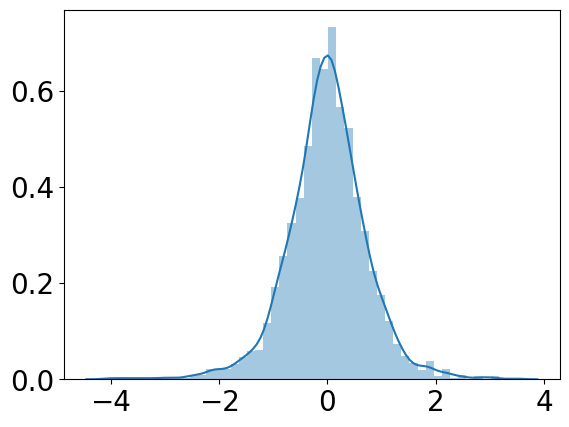

In [44]:
shapiro_ok = False
critical_threshold = 0.05
        
 # standardization
X = np.array(residuals).reshape(-1,1)
standardized_X = RobustScaler().fit_transform(X)
    
    # shapiro test
small_size_standardized_X = np.random.choice(standardized_X.reshape(-1), size=30, replace=False)
if stats.shapiro(small_size_standardized_X)[1] >= critical_threshold:
    shapiro_ok = True
else:
    shapiro_ok = False
    

display(shapiro_ok)
sns.distplot(residuals);


In [45]:
#  data preparation
data = dataset[['income', 'country_mean_income', 'Gini_last', 'parent_quantile']].dropna()
data['income'] = np.log(data['income'])
data['country_mean_income'] = np.log(data['country_mean_income'])
data = np.array(data)

# fitting regression
coeff, intercept, residuals = regression_coeff_score (X=data[:,1:], y=data[:,0].reshape(-1, 1))

print(coeff, intercept)

R² train : 0.75
R² test : 0.75
[[ 0.98923187 -0.01706536  0.00886912]] [0.01902111]


In [46]:
X = pd.DataFrame(linear)
X

data

array([[  7.74846002,   8.01886724,  33.1875    ,   1.        ],
       [  7.74846002,   8.01886724,  33.1875    ,   1.        ],
       [  7.74846002,   8.01886724,  33.1875    ,   1.        ],
       ...,
       [ 10.48430555,   8.66504662,  63.        , 100.        ],
       [ 10.48430555,   8.66504662,  63.        , 100.        ],
       [ 10.48430555,   8.66504662,  63.        , 100.        ]])

In [47]:
anova

,CC,log_income
0,ALB,7.748460
1,ALB,7.229114
2,ALB,8.208219
3,ALB,8.008698
4,ALB,7.475906
...,...,...
21317,USA,6.496775
21448,VEN,5.141664
21498,VNM,5.455321
21646,YEM,5.087596


True

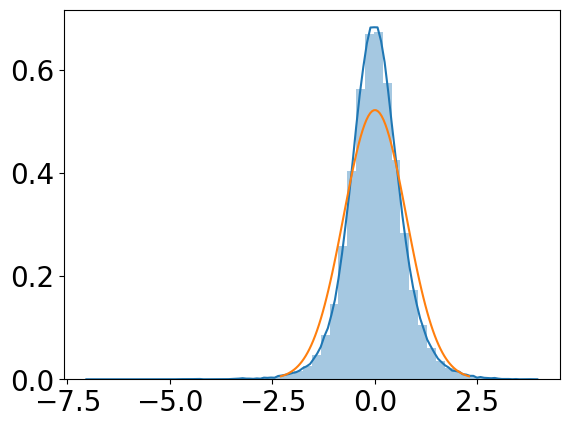

In [48]:
shapiro_ok = False
critical_threshold = 0.05
        
 # standardization
X = np.array(residuals).reshape(-1,1)
standardized_X = RobustScaler(with_scaling=True, with_centering=False).fit_transform(X)
    
    # shapiro test
small_size_standardized_X = np.random.choice(standardized_X.reshape(-1), size=50, replace=False)
if stats.shapiro(small_size_standardized_X)[1] >= critical_threshold:
    shapiro_ok = True
else:
    shapiro_ok = False
    

display(shapiro_ok)
sns.distplot(residuals);
# si normal résidu lié au hasard

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = small_size_standardized_X.var()
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [49]:
x_bar = small_size_standardized_X.sum()/len(small_size_standardized_X) # moyenne
variance = ((small_size_standardized_X - x_bar)**2).mean()
variance

standardized_X.var()

0.7319695561160596

In [50]:
 # standardization
X = np.array(residuals).reshape(-1,1)
standardized_X = RobustScaler().fit_transform(X)
    
    # shapiro test
small_size_standardized_X = np.random.choice(standardized_X.reshape(-1), size=50, replace=False)
if stats.shapiro(small_size_standardized_X)[1] >= critical_threshold:
    shapiro = True
else:
    shapiro = False
    
shapiro

False

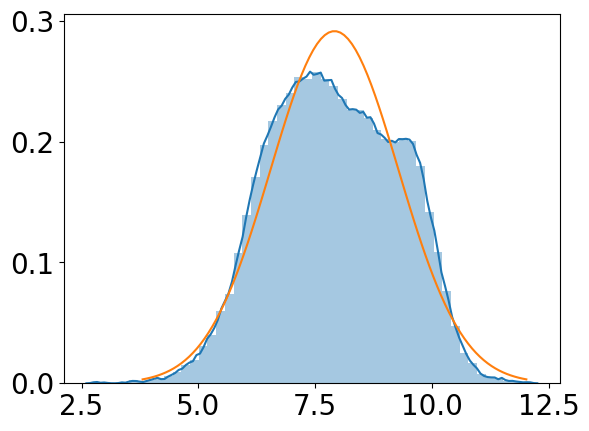

In [51]:
sns.distplot(data[:,0]);


mu = data[:,0].mean()
variance = data[:,0].var()
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [52]:
from sklearn.cluster import KMeans
X = data[:, 1:]
km = KMeans(n_clusters=2, random_state=0).fit(X)
predict = km.predict(X)

In [53]:
# sns.distplot(data[:,0]);
mask = df['Cluster'] == 1
sns.distplot(df.loc[mask, 'Y'], color="y")
sns.distplot(df.loc[~mask, 'Y'], color="r")

NameError: name 'df' is not defined

In [ ]:
df = pd.DataFrame({'Y': data[:, 0], 'Cluster':predict})

# # sns.distplot(data[:,0]);
# mask = df['Cluster'] == 1
# sns.distplot(df.loc[mask, 'Y'], color="y")
# sns.distplot(df.loc[~mask, 'Y'], color="r")


In [ ]:
df = pd.DataFrame({'Y': data[:, 0], 'Cluster':predict})

g = sns.FacetGrid(df, hue='Cluster', palette="Set1")
g = (g.map(sns.distplot, "Y", hist=False))